In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.special import boxcox, inv_boxcox
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [2]:
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")


In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [26]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        # plt.tight_layout()
    plt.show()
    return

In [67]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [5]:
series = robberies_in_boston['Count']

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


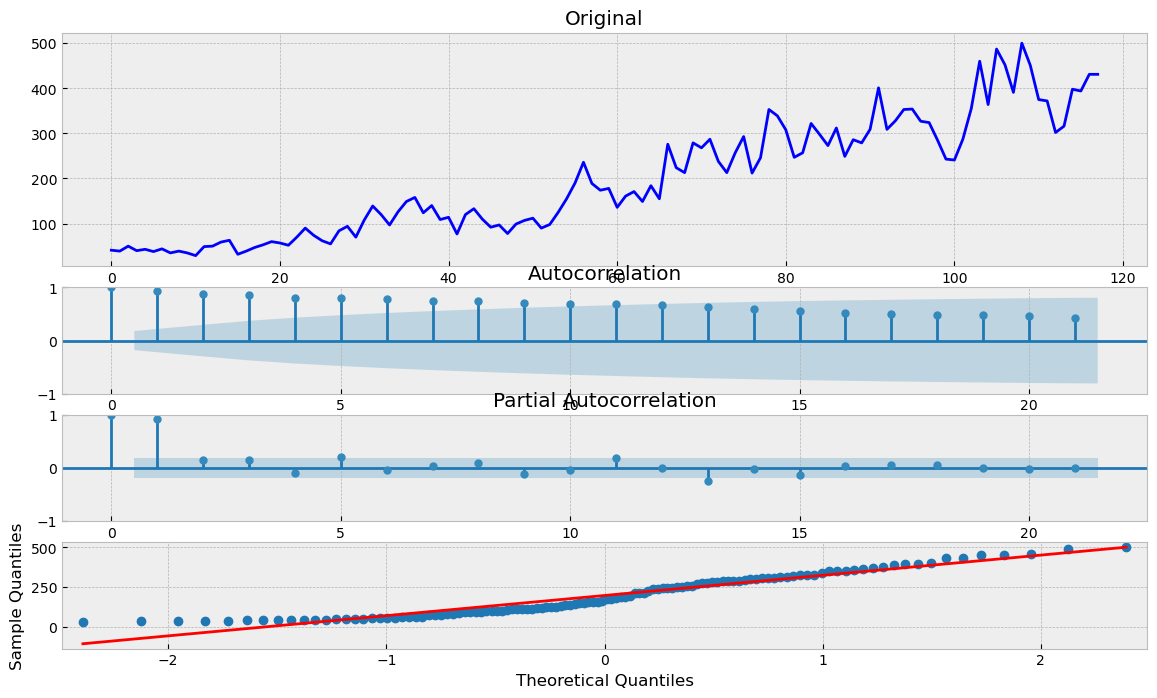

In [27]:
tsplot(series)

In [18]:
X = boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                  -2.013161
p-value                          0.280833
#Lags Used                      10.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


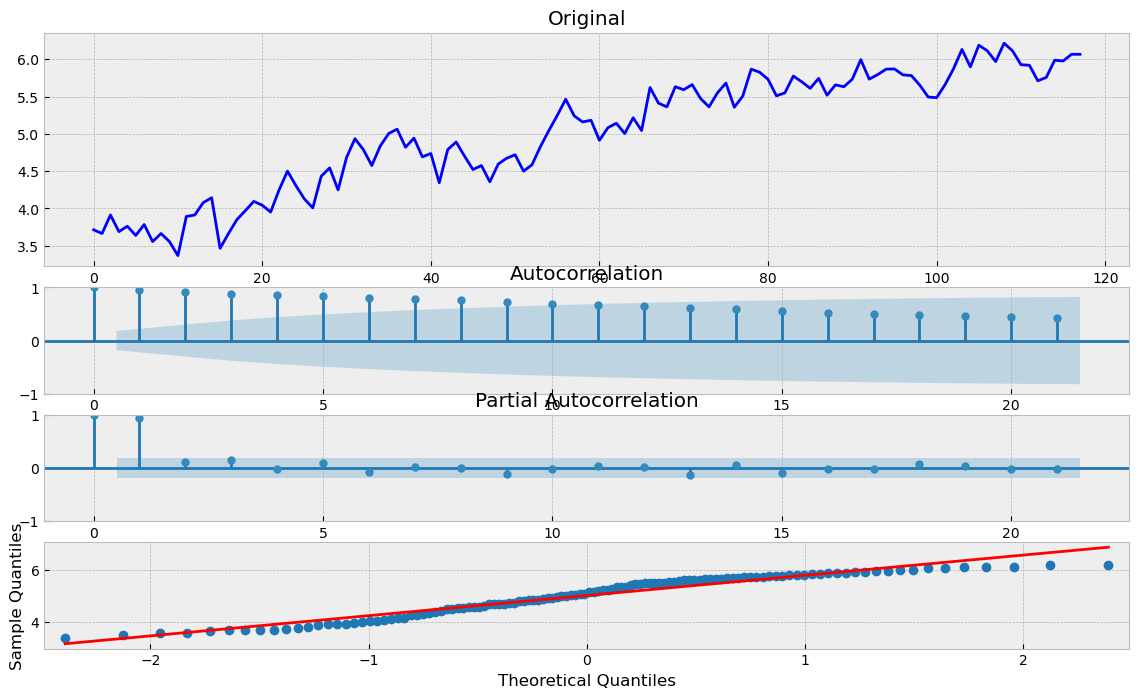

In [28]:
tsplot(X)

In [85]:
def get_best_ARIMA(y, trend = 'c'):
    best_aic = np.inf 
    best_order = None
    best_mdl = None
    for i in range(5):
        for d in range(5):
            for j in range(5):
                tmp_mdl = ARIMA(y, order=(i,d,j)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_mdl = tmp_mdl
                    best_order = (i, d, j)
    print(best_order)
    return best_mdl


In [87]:
arima1 = get_best_ARIMA(series)


(4, 2, 4)


Results of Dickey-Fuller Test:
Test Statistic                -1.083754e+01
p-value                        1.647398e-19
#Lags Used                     0.000000e+00
Number of Observations Used    1.170000e+02
Critical Value (1%)           -3.487517e+00
Critical Value (5%)           -2.886578e+00
Critical Value (10%)          -2.580124e+00
dtype: float64


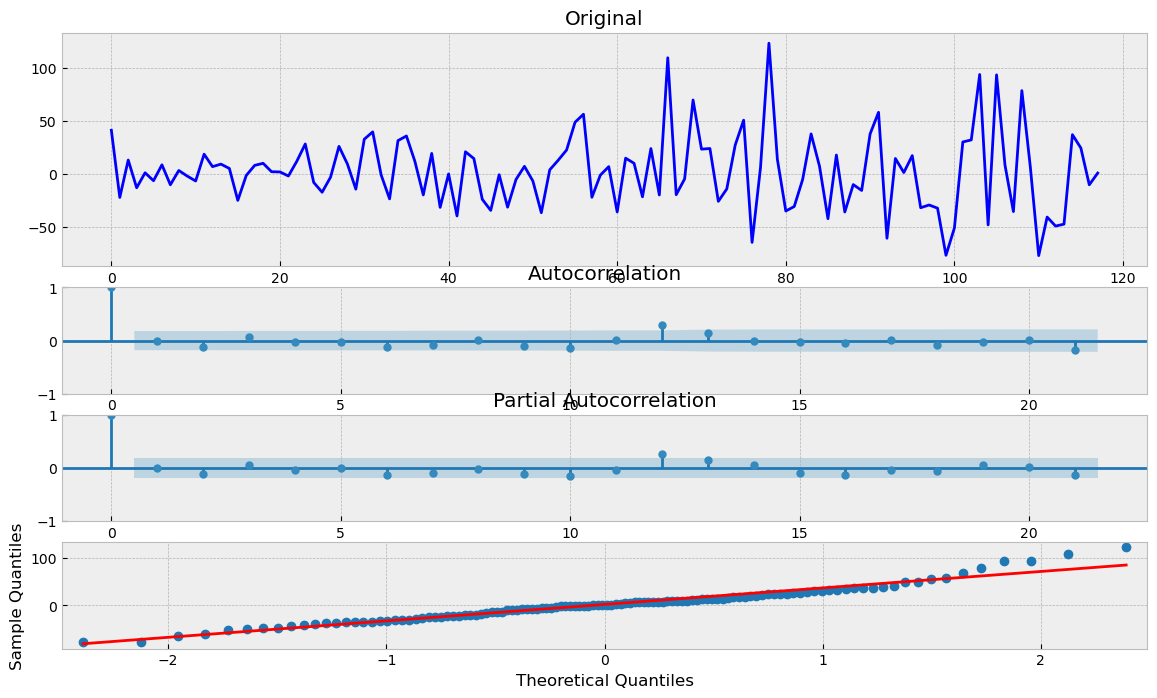

In [77]:
tsplot(arima1.resid)

In [78]:
rmse(series, arima1.predict())


34.96197064159089

Внешне график остатков похож на стационарный. RMSE = 34.96197064159089

Попробуем применить к ряду преобразование бокса кокса

In [79]:
series_bc = boxcox(series, 0)

In [80]:
arima2 = get_best_ARIMA(series_bc)

Results of Dickey-Fuller Test:
Test Statistic                 -22.373837
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    117.000000
Critical Value (1%)             -3.487517
Critical Value (5%)             -2.886578
Critical Value (10%)            -2.580124
dtype: float64


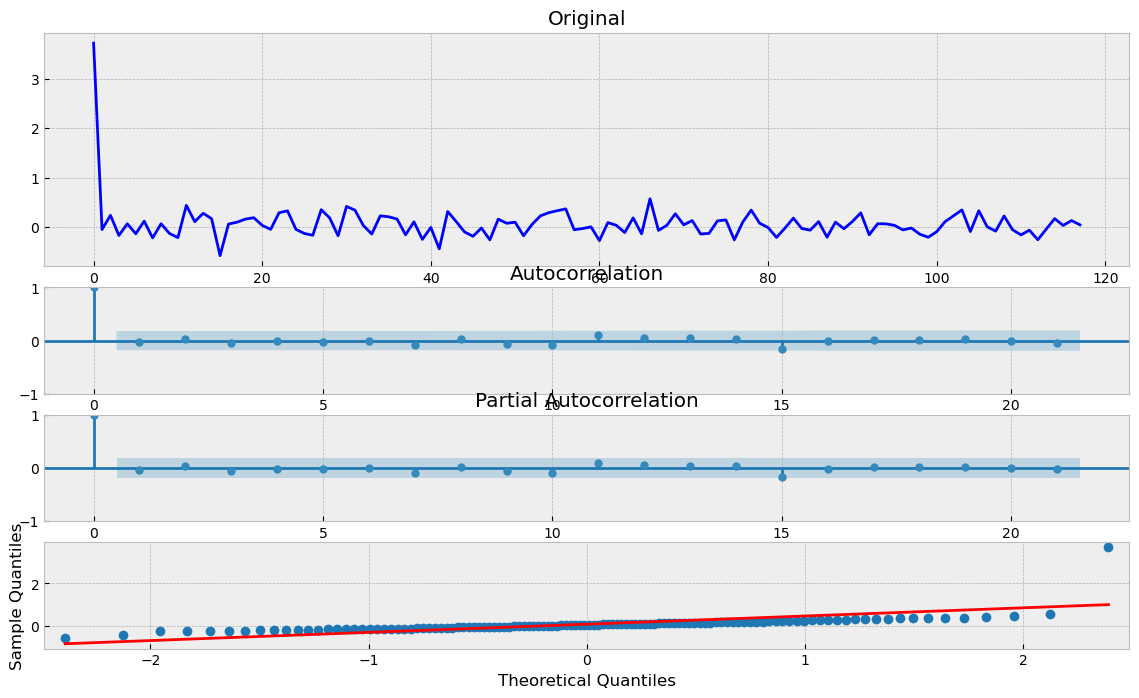

In [81]:
tsplot(arima2.resid)

In [83]:
rmse(series, inv_boxcox(arima2.predict(), 0))

39.07041327033975

Вторая модель показала худший результат. Оставляем модель ARIMA без преобразований boxcox
# А теперь попробуем ансамбль деревьев
Лучший p = 4


In [101]:
X = np.array([series[i:i+5].to_list() for i in range(0, len(series) - 5)])

In [106]:
y = X[:,4:]
X = X[:,:4]

In [110]:
from sklearn.ensemble import RandomForestRegressor # регрессия
clf_rf = RandomForestRegressor(
	n_estimators=10, 
	criterion='squared_error'
)

In [111]:
clf_rf.fit(X, y)

RandomForestRegressor(n_estimators=10)

In [112]:
y_pred = clf_rf.predict(X)

In [113]:
rmse(y, y_pred)

19.492185863430333

In [116]:
y.reshape(-1)

array([ 43,  38,  44,  35,  39,  35,  29,  49,  50,  59,  63,  32,  39,
        47,  53,  60,  57,  52,  70,  90,  74,  62,  55,  84,  94,  70,
       108, 139, 120,  97, 126, 149, 158, 124, 140, 109, 114,  77, 120,
       133, 110,  92,  97,  78,  99, 107, 112,  90,  98, 125, 155, 190,
       236, 189, 174, 178, 136, 161, 171, 149, 184, 155, 276, 224, 213,
       279, 268, 287, 238, 213, 257, 293, 212, 246, 353, 339, 308, 247,
       257, 322, 298, 273, 312, 249, 286, 279, 309, 401, 309, 328, 353,
       354, 327, 324, 285, 243, 241, 287, 355, 460, 364, 487, 452, 391,
       500, 451, 375, 372, 302, 316, 398, 394, 431])

Results of Dickey-Fuller Test:
Test Statistic                  -4.418038
p-value                          0.000276
#Lags Used                       4.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


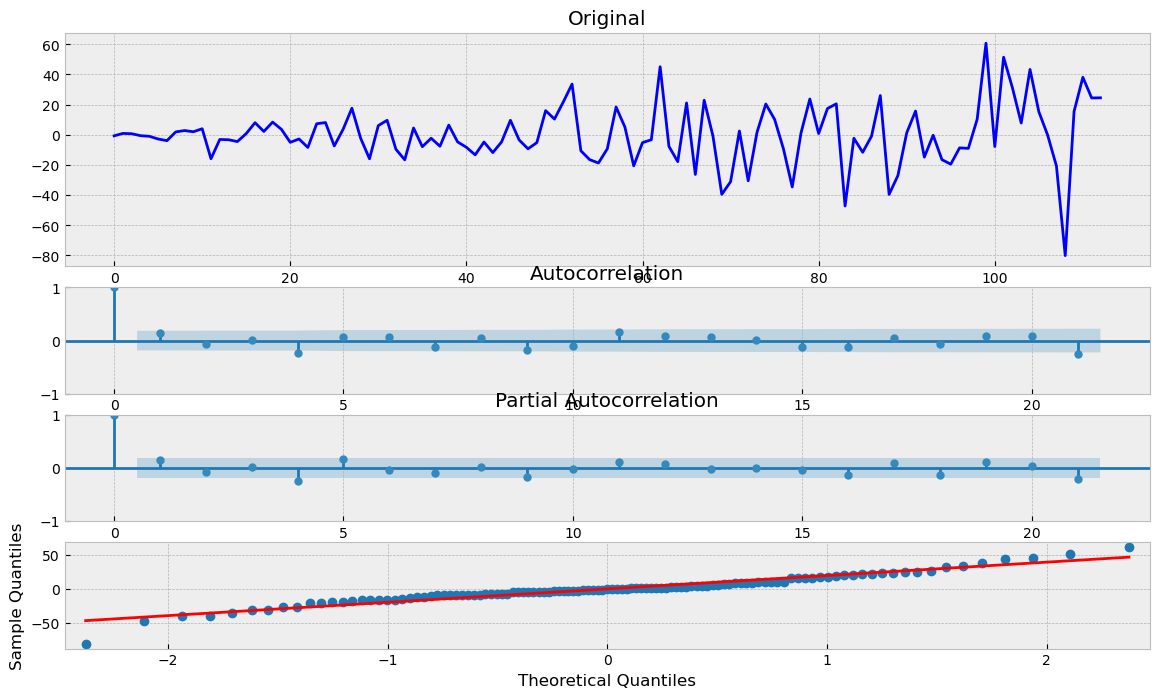

In [117]:
tsplot(y.reshape(-1) - y_pred.reshape(-1))

Ансамбль выдал лучший результат, чем ARIMA